/home/kd/Desktop/proj/apr/Punjabi_ASR/speech_utils.py:13: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/datasets/load.py:759: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Dataset summary: 
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration'],
        num_rows: 22022
    })
    test: Dataset({
        features: ['audio', 'text', 'duration'],
        num_rows: 178
    })
})
train duration in hours: 39.66
test duration in hours: 0.35
Max duration: 21.993 seconds
Min duration: 0.227 seconds
Avg duration: 6.486943192567567 seconds

Max text length: 240 characters
Min text length: 1 characters
Avg text length: 72.47216216216216 characters



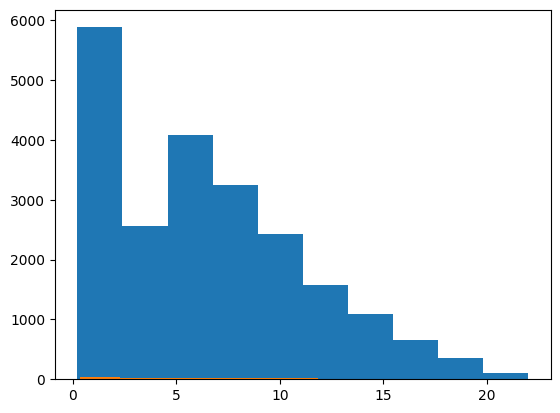

In [1]:
import faulthandler
faulthandler.enable()


from datasets import load_from_disk, concatenate_datasets, DatasetDict
import IPython.display as ipd
import speech_utils as su
import random
import numpy as np
from transformers import Wav2Vec2CTCTokenizer
from transformers import SeamlessM4TFeatureExtractor
from transformers import Wav2Vec2BertProcessor
from transformers import Wav2Vec2BertForCTC
from transformers import TrainingArguments
from transformers import Trainer
from functools import partial

import numpy as np
import random
import torch
from datasets import load_metric

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
from  data_collator import DataCollatorCTCWithPadding

import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_w2v-bert_teacher-model.ipynb'


# for trying training on single dataset source
ds = load_from_disk('/home/kd/Desktop/proj/apr/Punjabi_ASR/datasets/IndicVoice_Verbatim_Alignment_Filtered')
su.get_summary(ds)

In [2]:
ds_check = concatenate_datasets([ds['train'], ds['test']])
chars_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', ]
# chars_list = ['\u200b', '\u200c']
# su.check_sents_count(chars_list, ds_check)
su.check_sents_count_in_list(chars_list, ds_check,)

Count: 0


Removed 0 audio samples
Removed 0 audio samples
Removed 36 sentences
Removed 1 sentences
Removed 3 text samples
Removed 1 text samples
Dataset summary: 
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 21983
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 176
    })
})
train duration in hours: 39.53
test duration in hours: 0.34
Max duration: 21.993 seconds
Min duration: 0.227 seconds
Avg duration: 6.47711182815109 seconds

Max text length: 240 characters
Min text length: 2 characters
Avg text length: 72.37790514012366 characters



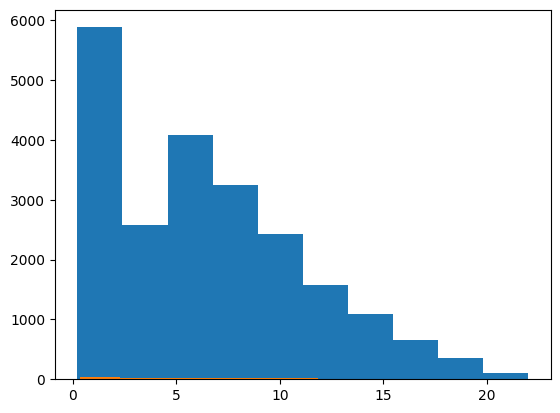

In [3]:

ds['train'] = su.remove_audio_samples(ds['train'])
ds['test'] = su.remove_audio_samples(ds['test'])
ds = su.normalize_text_ds(ds, remove_digits=True)
ds['train'] = su.remove_text_samples(ds['train'], column_name='normalized_text', min_text_length=1)
ds['test'] = su.remove_text_samples(ds['test'], column_name='normalized_text')
su.get_summary(ds, text_column='normalized_text')


/tmp/ipykernel_1914466/2469695718.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/21983 [00:00<?, ?it/s]

 > Number of words: 19302


/tmp/ipykernel_1914466/2469695718.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/21983 [00:00<?, ?it/s]

 > Number of unique text lengths: 239
 > Number of sentences with length 1: 0
Mean:  0.11051577245388534
Std:  0.06274034395884132


/tmp/ipykernel_1914466/2469695718.py:91: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm(data):


  0%|          | 0/21983 [00:00<?, ?it/s]

Text(0.5, 1.0, 'audio length distribution')

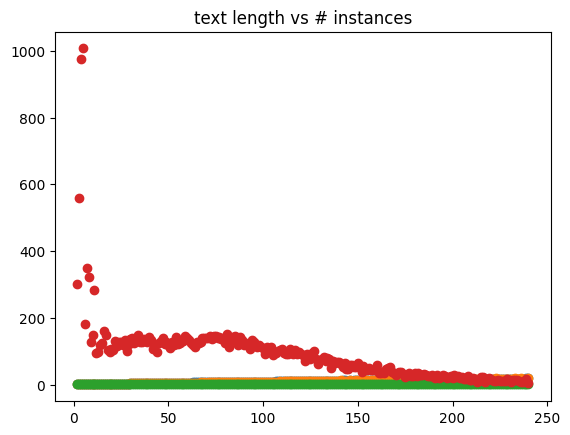

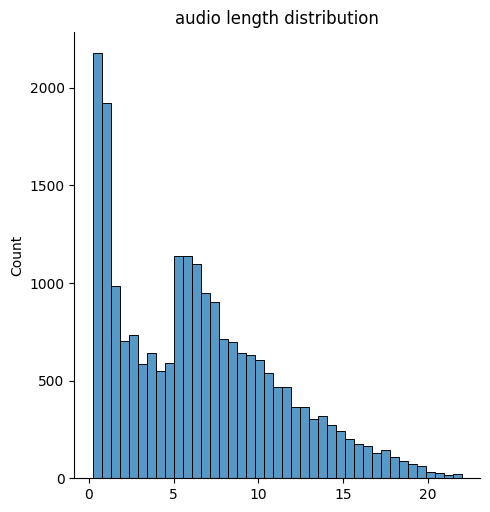

In [4]:
texts = ds['train']['normalized_text']
durations = ds['train']['duration']

import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from matplotlib import pylab as plt
%matplotlib inline
from collections import Counter
from scipy.stats import norm

data = []
for t, d in zip(texts, durations):
    data.append((d,t))

# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))


text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[0]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

print(" > Number of unique text lengths: {}".format(len(text_vs_avg)))

print(" > Number of sentences with length 1: {}".format(text_len_counter[1]))
# for item in data:
#     if item[0] <= 1:
#         print(item)

sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[0]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)

mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print("Mean: ", mean)
print("Std: ", std)

dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[0]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        #print(item)
        pass

dist = norm(mean, std)

plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

audio_lens = []
for item in tqdm(data):
    audio_len = item[0]
    audio_lens.append(audio_len)

sns.displot(audio_lens)
plt.title("audio length distribution")

In [5]:
import pandas as pd

def get_indexes_to_accept(ds, split_check):
    texts = ds[split_check]['normalized_text']
    durations = ds[split_check]['duration']

    text_lengths = [len(text) for text in texts]
    df = pd.DataFrame({
        'text_length': text_lengths,
        'audio_duration': durations
    })


    # Compute the IQR for text length
    Q1_text = df['text_length'].quantile(0.25)
    Q3_text = df['text_length'].quantile(0.75)
    IQR_text = Q3_text - Q1_text

    # Compute the IQR for mean audio duration
    Q1_audio = df['audio_duration'].quantile(0.25)
    Q3_audio = df['audio_duration'].quantile(0.75)
    IQR_audio = Q3_audio - Q1_audio

    # Define a condition for filtering out outliers in text length
    condition_text = (df['text_length'] >= (Q1_text - 1.5 * IQR_text)) & (df['text_length'] <= (Q3_text + 1.5 * IQR_text))

    # Define a condition for filtering out outliers in audio duration
    condition_audio = (df['audio_duration'] >= (Q1_audio - 1.5 * IQR_audio)) & (df['audio_duration'] <= (Q3_audio + 1.5 * IQR_audio))


    # get indexes where condition_length is True as int
    indexes_text = df[condition_text].index.tolist()
    # get indexes where condition_audio is True
    indexes_audio = df[condition_audio].index.to_list()
    # get indexes where condition_length is False
    indexes_text_false = df[~condition_text].index.to_list()
    # get indexes where condition_audio is False
    indexes_audio_false = df[~condition_audio].index.to_list()

    # print len summary
    print(len(text_lengths), len(durations))
    print(len(indexes_text), len(indexes_audio))
    print(len(indexes_text_false), len(indexes_audio_false))

    # check count of intersection of false indexes
    print('intersection of outlier indexes for text_length and audio duration')
    print(len(set(indexes_text_false) & set(indexes_audio_false)))

        
    indexes_to_reject = list(set(set(indexes_text_false).union(set(indexes_audio_false))))
    indexes_to_accept = list(set(range(len(texts))) - set(indexes_to_reject))
  
    print(f'len of indexes to accept: {len(indexes_to_accept)} and len of indexes to reject: {len(indexes_to_reject)}')
    return indexes_to_accept, indexes_to_reject


train_idx, train_idx_rej = get_indexes_to_accept(ds, 'train')
print('------------------------------------------')
test_idx, test_idx_rej = get_indexes_to_accept(ds, 'test')



21983 21983
21979 21930
4 53
intersection of outlier indexes for text_length and audio duration
0
len of indexes to accept: 21926 and len of indexes to reject: 57
------------------------------------------
176 176
176 176
0 0
intersection of outlier indexes for text_length and audio duration
0
len of indexes to accept: 176 and len of indexes to reject: 0


In [6]:
ds['train'] = ds['train'].select(train_idx)
ds['test'] = ds['test'].select(test_idx)

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 21926
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 176
    })
})

In [8]:
# Download noise samples
import subprocess
import wget
import glob
import tarfile
import librosa  
import soundfile as sf
import os

# Download and unzip the clean audio file.
noise_samples = '/mnt/sea/speech/noise_samples.zip'
if not os.path.exists(noise_samples):
    rirs_noises_url = 'https://www.openslr.org/resources/28/rirs_noises.zip'  
    rirs_noises_path = wget.download(rirs_noises_url, noise_samples)
    print(f"Dataset downloaded at: {rirs_noises_path}")
else:
    print("Zipfile already exists.")
    rirs_noises_path = noise_samples

Zipfile already exists.


In [9]:
from zipfile import ZipFile
noise_samples_ext = '/mnt/sea/speech/noise_samples'
if not os.path.exists(noise_samples_ext):
    try:
        with ZipFile(rirs_noises_path, "r") as zipObj:
            zipObj.extractall(noise_samples_ext)
            print("Extracting noise data complete")
        # Convert 8-channel audio files to mono-channel
        wav_list = glob.glob(noise_samples_ext + '/RIRS_NOISES/**/*.wav', recursive=True)
        for wav_path in wav_list:
            mono_wav_path = wav_path[:-4] + '_mono.wav'
            cmd = f"sox {wav_path} {mono_wav_path} remix 1"
            subprocess.call(cmd, shell=True)
        print("Finished converting the 8-channel noise data .wav files to mono-channel")
    except Exception as e:
        print("Not extracting. Extracted noise data might already exist.")
        print(e)
else: 
    print("Extracted noise data already exists. Proceed to the next step.")

# Let's create the following list of noise samples to better showcase the effect of SNR in synthesizing noisy audio files.
noise_sample_list = [
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0057_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0113_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0232_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0532_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0533_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0603_mono.wav',
                    '/RIRS_NOISES/pointsource_noises/noise-free-sound-0605_mono.wav',
                   ]

# # display the noise samples
# for noise_sample in noise_sample_list:
#     file_path = noise_samples_ext + noise_sample
#     ipd.display(ipd.Audio(filename=file_path, rate=16000))

Extracted noise data already exists. Proceed to the next step.


In [10]:

type1 = '/mnt/sea/speech/noise_samples/RIRS_NOISES/pointsource_noises'
type2 = '/mnt/sea/speech/noise_samples/RIRS_NOISES/real_rirs_isotropic_noises'
list1 = []
list2 = []
for root, dirs, files in os.walk(type1):
    for file in files:
        if file.endswith("_mono.wav"):
            list1.append(os.path.join(root, file))
for root, dirs, files in os.walk(type2):
    for file in files:
        if file.endswith("_mono.wav"):
            list2.append(os.path.join(root, file))

print(f"Total number of noise samples in {type1}: {len(list1)} and {type2}: {len(list2)}")
# use 200 samples for list2 - because it's mostly very silent or in other words on noise
noise_sample_list = list1 + list2[:200]

Total number of noise samples in /mnt/sea/speech/noise_samples/RIRS_NOISES/pointsource_noises: 843 and /mnt/sea/speech/noise_samples/RIRS_NOISES/real_rirs_isotropic_noises: 417


In [11]:
# function to read audio
def audioread(path = None, audio_arr = None,sr = 16000, norm = True, start=0, stop=None):
    if path is None and audio_arr is None:
        raise ValueError("Either path or audio_arr should be provided")
    
    if path is not None:
        path = os.path.abspath(path)
        if not os.path.exists(path):
            raise ValueError("[{}] does not exist!".format(path))
        try:
            x, sr = sf.read(path, start=start, stop=stop)
        except RuntimeError:  # fix for sph pcm-embedded shortened v2
            print('WARNING: Audio type not supported')
    
    if audio_arr is not None:
        x = np.array(audio_arr)

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x ** 2).mean() ** 0.5
            if rms == 0:
               rms = 1
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0)/x.shape[0]
        if norm:
            rms = (x ** 2).mean() ** 0.5
            if rms == 0:
               rms = 1
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    
# function to mix a clean speech with a noise sample at a specified SNR level
def snr_mixer(clean, noise, snr):
    # Normalizing to -25 dB FS
    rmsclean = (clean**2).mean()**0.5
    if rmsclean == 0:
       rmsclean = 1
    
    scalarclean = 10 ** (-25 / 20) / rmsclean
    clean = clean * scalarclean
    rmsclean = (clean**2).mean()**0.5

    rmsnoise = (noise**2).mean()**0.5
    if rmsnoise == 0:
       rmsnoise = 1
    
    scalarnoise = 10 ** (-25 / 20) /rmsnoise
    noise = noise * scalarnoise
    rmsnoise = (noise**2).mean()**0.5
    if rmsnoise == 0:
       rmsnoise = 1
    
    # Set the noise level for a given SNR
    noisescalar = np.sqrt(rmsclean / (10**(snr/20)) / rmsnoise)
    noisenewlevel = noise * noisescalar
    noisyspeech = clean + noisenewlevel
    return clean, noisenewlevel, noisyspeech

# Add zeros to a noise sample to make it of the same duration as the clean audio.
def concatenate_noise_sample(noise, fs, len_clean):
    silence_length = 0.5
    while len(noise) <= len_clean:
       noiseconcat = np.append(noise, np.zeros(int(fs*silence_length)))
       noise = np.append(noiseconcat, noise)

    if noise.size > len_clean:
       noise = noise[0:len_clean]

    return noise



In [12]:


c_size = len(ds['train'])-1 
n_size = len(noise_sample_list)-1 

idx_c = random.randint(0, c_size)
idx_n = random.randint(0, n_size)


# Now, let's mix the selected clean audio and noise sample at 0dB SNR.
SNRs = [40, 50]

SNR = random.choice(SNRs)
print(f"Selected clean audio index: {idx_c} {c_size} and noise sample index: {idx_n} {n_size} with SNR: {SNR} dB")
clean_audio_arr = ds['train'][idx_c]['audio']['array']
noise_sample_f_name = noise_sample_list[idx_n]

clean, fs = audioread(audio_arr=clean_audio_arr, sr=16000)
noise, n_fs = audioread(path=noise_sample_f_name)

if len(noise) > len(clean):
   noise = noise[0:len(clean)]
elif len(noise) < len(clean):
   noise = concatenate_noise_sample(noise, n_fs, clean.size)

clean_snr, noise_snr, noisy_snr = snr_mixer(clean=clean, noise=noise, snr=SNR)
print("Finished creating noisy file.\n******")

display(ipd.Audio(noisy_snr, rate=16000, autoplay=False))

Selected clean audio index: 15064 21925 and noise sample index: 419 1042 with SNR: 50 dB
Finished creating noisy file.
******


In [13]:
ds['train']

Dataset({
    features: ['audio', 'text', 'duration', 'normalized_text'],
    num_rows: 21926
})

In [14]:
update_vocab = False

if update_vocab:
  def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

  vocab_train = ds['train'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds['train'].column_names)
  vocab_test = ds['test'].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds['test'].column_names)

  vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))

  vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
  vocab_dict["|"] = vocab_dict[" "]
  del vocab_dict[" "]
  vocab_dict["[UNK]"] = len(vocab_dict)
  vocab_dict["[PAD]"] = len(vocab_dict)
  len(vocab_dict)

  import json
  with open('vocab.json', 'w') as vocab_file:
      json.dump(vocab_dict, vocab_file)

In [15]:
ckpt_path = '/home/kd/Desktop/proj/apr/Punjabi_ASR/checkpoints/wav2vec2-bert-pa_indicvoice_verbatim_2/checkpoint-3100'
# ckpt_path = None

In [16]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = SeamlessM4TFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
processor = Wav2Vec2BertProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
n_size = len(noise_sample_list)-1 

from functools import partial

def augment_and_prepare_dataset(batch, speed):
    audio = batch["audio"]
    clean_audio_arr = audio["array"]
    clean, fs = audioread(audio_arr=clean_audio_arr, sr=audio['sampling_rate'], norm=False) # Let's don't normalize the audio because we aren't doing it during inference
    clean = librosa.effects.time_stretch(clean, rate=speed)
    batch["input_features"] = processor(clean, sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["input_length"] = len(batch["input_features"][0])
    batch["labels"] = processor(text=batch["normalized_text"]).input_ids

    return batch


def prepare_dataset(batch, add_noise=True):
    # batch is single row 
    audio = batch["audio"]

    idx_n = random.randint(0, n_size)
    SNR = random.choice(SNRs)
    noise_sample_f_name = noise_sample_list[idx_n]
    clean_audio_arr = audio["array"]
    clean, fs = audioread(audio_arr=clean_audio_arr, sr=audio['sampling_rate'], norm=False) # Let's don't normalize the audio because we aren't doing it during inference

    if add_noise:
        noise, n_fs = audioread(path=noise_sample_f_name, norm=False)

        if len(noise) > len(clean):
            noise = noise[0:len(clean)]
        elif len(noise) < len(clean):
            noise = concatenate_noise_sample(noise, n_fs, clean.size)

        clean_snr, noise_snr, noisy_snr = snr_mixer(clean=clean, noise=noise, snr=SNR)
        noised_audio = noisy_snr
        batch["input_features"] = processor(noised_audio, sampling_rate=audio["sampling_rate"]).input_features[0]
    else:
        batch["input_features"] = processor(clean, sampling_rate=audio["sampling_rate"]).input_features[0]
        
    batch["input_length"] = len(batch["input_features"][0])
    batch["labels"] = processor(text=batch["normalized_text"]).input_ids

    return batch

In [18]:

rand_int = random.randint(0, len(ds['train'])-1)
print(ds['train'][rand_int]["normalized_text"])
ipd.display(ipd.Audio(data=ds['train'][rand_int]["audio"]["array"], autoplay=True, rate=16000))
rand_int = random.randint(0, len(ds['train'])-1)
print("Target text:", ds['train'][rand_int]["normalized_text"])
print("Input array shape:", ds['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", ds['train'][rand_int]["audio"]["sampling_rate"])


print(ds)
ds_clean = ds['train']
ds_noisy = ds['train']
ds_fast = ds['train']
ds_fast2 = ds['train']

ds_clean = ds_clean.map(partial(prepare_dataset, add_noise=False), remove_columns=ds['train'].column_names, num_proc=1, batch_size=1)
ds_noisy = ds_noisy.map(partial(prepare_dataset, add_noise=True), remove_columns=ds['train'].column_names, num_proc=1, batch_size=1)
ds_fast = ds_fast.map(partial(augment_and_prepare_dataset, speed=1.1), remove_columns=ds['train'].column_names, num_proc=1, batch_size=1)
# ds_fast2 = ds_fast2.map(partial(augment_and_prepare_dataset, speed=1.4), remove_columns=ds['train'].column_names, num_proc=1, batch_size=1)

ds['train']  = concatenate_datasets([ds_clean, ds_noisy, ds_fast])
ds['test'] = ds['test'].map(partial(prepare_dataset, add_noise=False), remove_columns=ds['test'].column_names, num_proc=1, batch_size=1)

ds['train'] = ds['train'].shuffle(seed=56)
print(ds)
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

if ckpt_path is None:
    m = 'facebook/w2v-bert-2.0'
else:
    m = ckpt_path


ਛੋਟਾ ਹੁੰਦਾ ਜਦੋਂ ਮੈਂ ਪੰਜਵੀਂ ਜਮਾਤ ਦੇ ਵਿੱਚ ਹੁੰਦਾ ਸੀ


Target text: ਕਨੇਡਾ ਅਮਰੀਕਾ
Input array shape: (30209,)
Sampling rate: 16000
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 21926
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'normalized_text'],
        num_rows: 176
    })
})
DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 65778
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 176
    })
})


In [19]:

model = Wav2Vec2BertForCTC.from_pretrained(
    m, ignore_mismatched_sizes=True,
    apply_spec_augment = True, 
    ctc_loss_reduction="mean",
    ctc_zero_infinity=True,
    mask_time_prob=0.0, # default 0.05
    layerdrop=0.0, # default 0.1
    add_adapter=True,
    use_intermediate_ffn_before_adapter=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)


# model

In [20]:

batch_size = 8
accumulation_steps = 5
batch_size = 16
accumulation_steps = 1 
effective_batch_size = batch_size * accumulation_steps


training_args = TrainingArguments(
  output_dir='./checkpoints/wav2vec2-bert-pa_indicvoice_verbatim_2',
  # group_by_length=True,
  per_device_train_batch_size=batch_size,
  gradient_accumulation_steps=accumulation_steps,
  evaluation_strategy="steps",
  num_train_epochs=1.3,
  adam_beta1=0.9,
  adam_beta2=0.999,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,  
  weight_decay=0.01,
  learning_rate=5e-5,
  lr_scheduler_type="cosine",
  load_best_model_at_end=True,
  metric_for_best_model="wer",
  greater_is_better=False,
  warmup_ratio=0.33,
  dataloader_num_workers=2,
  dataloader_prefetch_factor=4,
  dataloader_persistent_workers=False,
  run_name='wav2vec2-bert-pa-indic-voice-filtered-teacher-model',
#   ignore_data_skip=True,
  save_total_limit=4,
  # push_to_hub=True,
  report_to= ["tensorboard","wandb"],
  resume_from_checkpoint=ckpt_path,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(su.compute_wer_metrics, processor=processor),
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    tokenizer=processor.feature_extractor,
)

print(model.device)

/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


cuda:0


In [21]:
ds

DatasetDict({
    train: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 65778
    })
    test: Dataset({
        features: ['input_features', 'input_length', 'labels'],
        num_rows: 176
    })
})

In [22]:
if ckpt_path is None:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=ckpt_path)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find train_w2v-bert_teacher-model.ipynb.
wandb: Currently logged in as: kdcyberdude. Use `wandb login --relogin` to force relogin


  0%|          | 0/3564 [00:00<?, ?it/s]

/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


{'loss': 0.1732, 'grad_norm': 1.8402031660079956, 'learning_rate': 4.462135223571639e-06, 'epoch': 1.13}
{'loss': 0.1352, 'grad_norm': 2.665114164352417, 'learning_rate': 4.276309746274368e-06, 'epoch': 1.14}
{'loss': 0.196, 'grad_norm': 1.1963090896606445, 'learning_rate': 4.112135088539901e-06, 'epoch': 1.14}
{'loss': 0.1907, 'grad_norm': 4.580859661102295, 'learning_rate': 3.933157010108942e-06, 'epoch': 1.15}
{'loss': 0.1735, 'grad_norm': 1.4036296606063843, 'learning_rate': 3.7578280512717003e-06, 'epoch': 1.15}
{'loss': 0.2083, 'grad_norm': 6.213484764099121, 'learning_rate': 3.586178581853367e-06, 'epoch': 1.15}
{'loss': 0.1998, 'grad_norm': 27.830474853515625, 'learning_rate': 3.418238334331772e-06, 'epoch': 1.16}
{'loss': 0.1658, 'grad_norm': 2.4477627277374268, 'learning_rate': 3.254036398687227e-06, 'epoch': 1.16}
{'loss': 0.2075, 'grad_norm': 3.6102755069732666, 'learning_rate': 3.0936012173636676e-06, 'epoch': 1.16}
{'loss': 0.1671, 'grad_norm': 1.7441428899765015, 'learni

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 0.21749821305274963, 'eval_wer': 0.20247678018575851, 'eval_runtime': 4.3433, 'eval_samples_per_second': 40.522, 'eval_steps_per_second': 5.065, 'epoch': 1.17}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


{'loss': 0.2, 'grad_norm': 3.524080753326416, 'learning_rate': 2.784141620326253e-06, 'epoch': 1.17}
{'loss': 0.1987, 'grad_norm': 5.7306413650512695, 'learning_rate': 2.635170808044077e-06, 'epoch': 1.17}
{'loss': 0.2107, 'grad_norm': 3.251328468322754, 'learning_rate': 2.4900739476612754e-06, 'epoch': 1.18}
{'loss': 0.1965, 'grad_norm': 5.57405948638916, 'learning_rate': 2.3488761723122393e-06, 'epoch': 1.18}
{'loss': 0.2115, 'grad_norm': 3.7844016551971436, 'learning_rate': 2.2116019397464716e-06, 'epoch': 1.19}
{'loss': 0.1839, 'grad_norm': 0.8999941349029541, 'learning_rate': 2.078275028092094e-06, 'epoch': 1.19}
{'loss': 0.1695, 'grad_norm': 1.903659462928772, 'learning_rate': 1.9489185317370983e-06, 'epoch': 1.19}
{'loss': 0.2298, 'grad_norm': 7.719648838043213, 'learning_rate': 1.82355485732901e-06, 'epoch': 1.2}
{'loss': 0.1596, 'grad_norm': 0.9519689083099365, 'learning_rate': 1.7022057198937096e-06, 'epoch': 1.2}
{'loss': 0.1964, 'grad_norm': 0.758033275604248, 'learning_rat

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 0.21544790267944336, 'eval_wer': 0.20495356037151702, 'eval_runtime': 4.3929, 'eval_samples_per_second': 40.064, 'eval_steps_per_second': 5.008, 'epoch': 1.2}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


{'loss': 0.1727, 'grad_norm': 1.8904021978378296, 'learning_rate': 1.4716344354887584e-06, 'epoch': 1.21}
{'loss': 0.1958, 'grad_norm': 1.7673883438110352, 'learning_rate': 1.3731865062078852e-06, 'epoch': 1.21}
{'loss': 0.1673, 'grad_norm': 1.5133607387542725, 'learning_rate': 1.267688433771788e-06, 'epoch': 1.21}
{'loss': 0.194, 'grad_norm': 2.1246981620788574, 'learning_rate': 1.1663011834072258e-06, 'epoch': 1.22}
{'loss': 0.1761, 'grad_norm': 2.050954580307007, 'learning_rate': 1.0690423170337555e-06, 'epoch': 1.22}
{'loss': 0.1794, 'grad_norm': 6.196640968322754, 'learning_rate': 9.759286814677303e-07, 'epoch': 1.23}
{'loss': 0.2054, 'grad_norm': 7.570696830749512, 'learning_rate': 8.869764055041502e-07, 'epoch': 1.23}
{'loss': 0.1296, 'grad_norm': 1.3945783376693726, 'learning_rate': 8.022008971229039e-07, 'epoch': 1.23}
{'loss': 0.1534, 'grad_norm': 2.620277166366577, 'learning_rate': 7.216168408198554e-07, 'epoch': 1.24}
{'loss': 0.1649, 'grad_norm': 1.5929820537567139, 'learn

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 0.21663159132003784, 'eval_wer': 0.20588235294117646, 'eval_runtime': 4.2791, 'eval_samples_per_second': 41.13, 'eval_steps_per_second': 5.141, 'epoch': 1.24}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


{'loss': 0.1768, 'grad_norm': 1.4979771375656128, 'learning_rate': 5.730781898758613e-07, 'epoch': 1.24}
{'loss': 0.1535, 'grad_norm': 3.9241909980773926, 'learning_rate': 5.051493245433775e-07, 'epoch': 1.25}
{'loss': 0.1616, 'grad_norm': 3.5327308177948, 'learning_rate': 4.4146336544927667e-07, 'epoch': 1.25}
{'loss': 0.1673, 'grad_norm': 7.101701259613037, 'learning_rate': 3.8203134403672903e-07, 'epoch': 1.26}
{'loss': 0.205, 'grad_norm': 1.9149596691131592, 'learning_rate': 3.268635548977633e-07, 'epoch': 1.26}
{'loss': 0.1878, 'grad_norm': 1.6434582471847534, 'learning_rate': 2.759695539900603e-07, 'epoch': 1.26}
{'loss': 0.1511, 'grad_norm': 3.124681234359741, 'learning_rate': 2.2935815698174045e-07, 'epoch': 1.27}
{'loss': 0.1469, 'grad_norm': 0.880486249923706, 'learning_rate': 1.870374377243078e-07, 'epoch': 1.27}
{'loss': 0.1639, 'grad_norm': 6.1096272468566895, 'learning_rate': 1.4901472685415475e-07, 'epoch': 1.27}
{'loss': 0.175, 'grad_norm': 1.7920893430709839, 'learning

  0%|          | 0/22 [00:00<?, ?it/s]

{'eval_loss': 0.21610961854457855, 'eval_wer': 0.20340557275541796, 'eval_runtime': 4.2391, 'eval_samples_per_second': 41.518, 'eval_steps_per_second': 5.19, 'epoch': 1.28}


/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/kd/anaconda3/envs/ai4bharat/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


{'loss': 0.1756, 'grad_norm': 2.489968776702881, 'learning_rate': 8.588892925590065e-08, 'epoch': 1.28}
{'loss': 0.1895, 'grad_norm': 0.9881479144096375, 'learning_rate': 6.079677694189045e-08, 'epoch': 1.28}
{'loss': 0.1625, 'grad_norm': 1.5782808065414429, 'learning_rate': 4.002449994932878e-08, 'epoch': 1.29}
{'loss': 0.1751, 'grad_norm': 22.408679962158203, 'learning_rate': 2.3575696374189548e-08, 'epoch': 1.29}
{'loss': 0.1614, 'grad_norm': 3.671696424484253, 'learning_rate': 1.145321541659028e-08, 'epoch': 1.3}
{'loss': 0.1589, 'grad_norm': 3.8570187091827393, 'learning_rate': 3.659156887245163e-09, 'epoch': 1.3}
{'train_runtime': 1204.3644, 'train_samples_per_second': 71.001, 'train_steps_per_second': 2.959, 'train_loss': 0.023239271341081957, 'epoch': 1.3}
